# Aligning GPT-2 to Generate Positive Content using Reinforcement Learning with Human Feedback RLHF) and Proximal Policy Optimization (PPO)

## What on earth is RLHF?

Fine-tuning LLMs are great but you often do not have control on the way the model behaves in terms of generating respones. This is where the aspect of **alignment** to human behavior, choices and preferences come in. Without the LLM being aligned to human preferences, you can expect more hallucinations, toxicity, undesired responses.

The authors of the seminal work **[InstructGPT](https://arxiv.org/pdf/2203.02155)** basically focused on this aspect of aligning the language models to human feedback (hence the name!). 

![](https://i.imgur.com/tq6p6zr.png)

Their work showcased how we can further fine-tune such models in a supervised way leverage human feedback and reinforcement learning to align them.

## Key Concepts:

- **Reinforcement Learning (RL)**: A machine learning paradigm where an agent learns to make decisions by performing actions and receiving _rewards or penalties_ .

- **Human Feedback**: Evaluations provided by humans that guide the learning process, ensuring the model's outputs align with human expectations and preferences.

## Use-Case: Use RLHF to Generate Positive Reviews with GPT-2

Reinforcement Learning with Human Feedback (RLHF) can be explained using the steps illustrated below. 

We'll walk through the process of making GPT-2 generate positive movie reviews.


## 1. Rollout - Standard Generation Process during training \ fine-tuning

- **Query:** You start with an incomplete movie review, for example, "This movie is."
- **Language Model (LM):** GPT-2 takes this input and generates a continuation, such as "really great!"
- **Response:** The generated continuation ("really great!") is what GPT-2 suggests as the completion of the review.

## 2. Evaluation
- **Query + Response:** The completed sentence, "This movie is really great!" is then evaluated.
- **Reward Model:** A separate model, called the reward model, assesses the quality of the response. It might be a classifier (like our BERT classifier), a set of rules, or even manual human feedback that judges whether the review is positive and well-formed.
- **Reward:** The reward model assigns a numerical score (reward) to the response based on how well it meets the desired criteria (in this case, being a positive review can get a high positive score >3 and negative review can get a low score < 1).

## 3. Optimization
- **Comparison with a Reference Model:** The GPT-2 model (model being fine-tuned and aligned) that generated the response is compared to a baseline or reference model, which can be an earlier, unoptimized version of GPT-2.
- **Log-Probabilities:** The likelihood (log-probabilities) of the generated response is calculated for both the active and reference models.
- **KL-Divergence (KL-div):** The difference between these probabilities (how much the active model's behavior deviates from the reference) is measured using KL-divergence.
- **PPO (Proximal Policy Optimization):** This is an algorithm that uses the reward and the difference in log-probabilities to adjust the model's parameters. The goal is to improve the model so it generates responses that receive higher rewards more consistently.
- **Final Update:** The model is optimized using policy gradients, balancing the reward and the deviation from the reference model to make GPT-2 better at generating positive reviews.

## Summary
In summary, RLHF for generating positive reviews involves having GPT-2 generate a review, evaluating how positive and well-formed the review is, and then fine-tuning GPT-2 based on this evaluation to improve future reviews. The process is iterative, with continuous adjustments to make the model produce better and more aligned responses over time.


<div style="text-align: center">
<img src='https://i.imgur.com/FfoswhJ.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


In this notebook we fine-tune GPT2 (small) to generate positive movie reviews based on the IMDB dataset. The model gets the start of a real review and is tasked to produce positive continuations. To reward positive continuations we use a BERT classifier to analyse the sentiment of the produced sentences and use the classifier's outputs as rewards signals for PPO training.

## What is PPO?

PPO, or **Proximal Policy Optimization**, is a type of reinforcement learning algorithm that helps a model (like GPT-2) learn better behaviors by making small, controlled updates to its policy. In this context, "policy" refers to the model's strategy for generating responses to inputs.

## How PPO Works in Simple Terms:

1. **Start with a Policy:**
   - Imagine the model has a set of rules or strategies it follows to generate text. This set of rules is called its "policy." Initially, the model uses a certain policy to decide how to respond to inputs. The model starts with an initial policy, based on how it was originally trained usually for LLMs

![](https://i.imgur.com/lTaMTmC.png)

2. **Evaluate the Policy:**
   - The model's current policy generates some responses to given inputs, and these responses are evaluated using the reward model. This evaluation tells us how good or bad the responses are (i.e., how well they match what we want, such as generating positive reviews).

3. **Calculate the Advantage:**
   - PPO compares how much better or worse the new policy (after generating a response) is compared to an older, reference policy. This comparison is called the "advantage." If the new policy is better (higher reward), that’s positive; if it's worse, that’s negative.

4. **Make Small Adjustments:**
   - Instead of making big changes to the policy (which might make the model behave unpredictably), PPO makes small, safe adjustments. It ensures that the updates are "proximal" or close to the previous policy, meaning the model doesn't stray too far from what it already knows.
   - This is done by using a technique called **clipping**. Clipping limits how much the policy can change in one update, preventing drastic changes that could lead to poor performance.

5. **Balance Exploration and Exploitation:**
   - PPO balances between two things: 
     - **Exploration** (trying new ways of generating responses) and 
     - **Exploitation** (sticking with what is already known to work well).
   - By carefully controlling updates, PPO allows the model to gradually improve its policy without making risky or unstable changes.

6. **Iterate:**
   - This process of making small updates, evaluating, and adjusting is repeated many times. Over time, the model’s policy becomes more and more refined, leading to better performance (in this case, generating more positive and higher-quality reviews).

## Why PPO is Effective:

- **Stability:** By making only small, controlled changes, PPO helps ensure that the model's learning process remains stable. It avoids the wild swings in behavior that can happen with larger updates.
- **Efficiency:** PPO is computationally efficient, meaning it can improve the model’s performance without needing excessive computational resources.

## In Summary:

PPO helps GPT-2 (or any other model) learn to generate better responses by carefully adjusting its strategy based on the rewards it receives. It makes sure the model improves steadily and safely, without making any sudden, drastic changes that could lead to poor performance.


You can see that we load simple GPT-2 pretrained model, however here is where you can take a SFT fine-tuned LLM also.

## Load data and models

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [1]:
#pip list |grep torchvision
#pip uninstall torchvision==0.19.1+cu12
!pip install torchvision==0.20.1 --quiet
!pip install trl==0.11.0 --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from trl import AutoModelForCausalLMWithValueHead
from transformers import AutoTokenizer

sft_model_name = 'openai-community/gpt2'
sft_model = AutoModelForCausalLMWithValueHead.from_pretrained(sft_model_name,
                                                              cache_dir="./sft",
                                                              device_map='cuda')
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(sft_model_name,
                                                              cache_dir="./ref",
                                                              device_map='cuda')
tokenizer = AutoTokenizer.from_pretrained(sft_model_name)

tokenizer.pad_token = tokenizer.eos_token

In [3]:
from transformers import pipeline

sft_model_pipe = pipeline("text-generation",
                          model='openai-community/gpt2',
                          device_map='cuda',
                          do_sample=True,
                          temperature=0.8,
                          max_new_tokens=50)

In [4]:
sft_model_pipe('Did not expect this movie',
               eos_token_id=tokenizer.eos_token_id,
               pad_token_id=tokenizer.eos_token_id,)

[{'generated_text': 'Did not expect this movie to be so popular. I think it would have helped me get more positive reviews and more people to participate.\n\nI am an enthusiastic fan of the movie. I love the fact that it was written by someone who was not afraid to take risks'}]

### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 250 characters and < 550 characters (just to train faster). 

Then we tokenize each text and cut it to random size with the `LengthSampler`.

In [5]:
from datasets import load_dataset

ds = load_dataset('imdb', split="train")
ds = ds.rename_columns({"text": "review"})
ds = ds.filter(lambda x: 550 >= len(x["review"]) > 250,
               batched=False)

In [6]:
ds

Dataset({
    features: ['review', 'label'],
    num_rows: 2456
})

In [7]:
df = ds.to_pandas()
df.head()

,review,label
0,If only to avoid making this type of film in t...,0
1,My interest in Dorothy Stratten caused me to p...,0
2,I think I will make a movie next weekend. Oh w...,0
3,Protocol is an implausible movie whose only sa...,0
4,Outlandish premise that rates low on plausibil...,0


In [8]:
df.label.value_counts()

label
1    1352
0    1104
Name: count, dtype: int64

In [9]:
from trl.core import LengthSampler

input_size = LengthSampler(min_value=2,
                           max_value=8)

input_size

In [10]:
# randomly returns a number between 2 - 8
input_size()

4

In [11]:
def tokenize(sample):
    sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
    sample["query"] = tokenizer.decode(sample["input_ids"])
    return sample

In [12]:
ds[0]

{'review': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': 0}

In [13]:
tokenize(ds[0])

{'review': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': 0,
 'input_ids': [1532, 691, 284, 3368],
 'query': 'If only to avoid'}

In [14]:
ds = ds.map(tokenize, batched=False)
ds.set_format(type="torch")
ds

Dataset({
    features: ['review', 'label', 'input_ids', 'query'],
    num_rows: 2456
})

In [15]:
ds[0]

{'review': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': tensor(0),
 'input_ids': tensor([1532,  691,  284]),
 'query': 'If only to'}

In [16]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [17]:
collator([ds[0], ds[1], ds[2]])

{'review': ["If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
  "My interest in Dorothy Stratten caused me to purchase this video. Although it had great actors/actresses, there were just too many subplots going on to retain interest. Plus it just wasn't that interesting. Dialogue was stiff and confusing and the story just flipped around too much to be believable. I was pretty disappointed in what I believe was one of Audrey Hepburn's last movies. I'll always love John Ritter best in slapstick. He was just too pat

### Initialize PPOTrainer
The `PPOTrainer` takes care of device placement and optimization later on:

In [18]:
from trl import PPOTrainer, PPOConfig

config = PPOConfig(
    model_name="openai-community/gpt2",
    query_dataset="imdb-sentiment",
    reward_model="lvwerra/distilbert-imdb",
    batch_size=16,
    mini_batch_size=16,
    learning_rate=2.5e-5,
    ratio_threshold=20
)


ppo_trainer = PPOTrainer(model=sft_model,
                         ref_model=ref_model,
                         tokenizer=tokenizer,
                         config=config,
                         dataset=ds,
                         data_collator=collator)


/opt/app-root/lib64/python3.11/site-packages/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(


### Load BERT classifier - Reward Model

We load a BERT classifier fine-tuned on the IMDB dataset, just like the model we fine-tuned earlier for sentiment classification. This is an LLM which can take in text and predict if its positive or negative sentiment.

In [19]:
ppo_trainer.accelerator.device

device(type='cuda')

In [20]:
reward_model = pipeline("sentiment-analysis",
                        model="lvwerra/distilbert-imdb",
                        device='cuda')

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [21]:
rm_kwargs = {"top_k": None,
             "function_to_apply": "none", # get raw logits value
             "batch_size": 16}

In [22]:
texts = ["this movie was really bad!!",
        "this movie was really good!!",
         "the movie was so not good"]

reward_model(texts, **rm_kwargs)

[[{'label': 'NEGATIVE', 'score': 2.335048198699951},
  {'label': 'POSITIVE', 'score': -2.726576328277588}],
 [{'label': 'POSITIVE', 'score': 2.557039737701416},
  {'label': 'NEGATIVE', 'score': -2.2947897911071777}],
 [{'label': 'NEGATIVE', 'score': 2.4509007930755615},
  {'label': 'POSITIVE', 'score': -2.928124189376831}]]

## Optimize model

### Training loop

The training loop consists of the following main steps:
1. Get the query responses from the policy network (GPT-2)
2. Get sentiments for query/responses from BERT
3. Optimize policy with PPO using the (query, response, reward) triplet

**Training time**

This step takes **~2h** on a V100 GPU with the above specified settings.

In [23]:
ppo_trainer

In [24]:
total_data = len(ds)
batch_size = 16
total_steps = total_data // batch_size
total_steps

153

We create a Reward Model function below such that if the reward model (BERT classifier) predicts positive sentiment for the generated text from the policy model (GPT-2) then we multiply the logit by 2 and if they predict negative sentiment as the most probably one then we half the logit score for that generated text.

In [25]:
import torch
from tqdm import tqdm

output_length_sampler = LengthSampler(12, 32)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}


for batch_num, batch in tqdm(enumerate(ppo_trainer.dataloader),
                             total=total_steps):
    query_tensors = batch["input_ids"]
    print('Batch Num:', batch_num)
    print('Query:', batch['query'])
    print('Query Shape:', len(query_tensors))

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])

    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]
    print('Responses:', batch["response"])
    print('Response Tensors Shape:', len(batch["response"]))

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    rm_outputs = reward_model(texts, **rm_kwargs)
    rewards = []
    probs = []
    for output in rm_outputs:
        if output[0]['score'] > output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(2*output[0]['score']))
            else:
                rewards.append(torch.tensor(0.5*output[0]['score']))
        elif output[1]['score'] > output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(2*output[1]['score']))
            else:
                rewards.append(torch.tensor(0.5*output[0]['score']))
        probs.append(output)

    print('Rewards:', rewards)
    print('Predicted Probs', probs)
    print('Rewards Shape:', len(rewards))
    break

  0%|          | 0/153 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Batch Num: 0
Query: ["I wasn't particularly impressed by this", 'I saw', 'The opening 5 minutes gave me', 'What a fun', '"Dressed to Kill', 'I saw', 'Absolutely one of', 'This movie has', '"9/11," hosted', 'From the', 'Ok I will sum', 'Ruth Gordon at', 'Along with the "', 'Being a fan of cheesy horror', 'With a', "I'm a"]
Query Shape: 16


  0%|          | 0/153 [00:02<?, ?it/s]

Responses: [' sub but I followed their refund policy carefully so I finally looked into making my own version. To my surprise, garbage happened', " a string of text lists pointing to date and time when I looked. I read each list and presumably didn't notice anything. Additionally,", ' nightmares, torches started burning, two slopes were exploding, wheels', " project, isn't it ? UPDATE: ^Ahhh, here comes Game", " (RnD): Don't cross the Docks, and walk down", " the girls go in the other apartment we were living with 'cause we just kind of kept thinking", " the funnier parts of it was Dartmouth wasn't simply there. When somebody was told to, we never", ' brought me closer to understanding the film and how much it can benefit people today to see it. It\'s been unreal for me."\n\nWith so many', " by MI6's Nick Paxson serve as testimony before Congress concerning and exposing the perpetrators of the 9/11 attacks. NSA Director Mike Rogers nor his", ' documentary, Yukino presents an intriguing

## Training GPT-2 with RLHF

Useful parameters to monitor when training with RLHF and PPO:

![](https://i.imgur.com/uMAlFDx.png)

We align the model with RLHF for 100 steps (batches of data) which is slightly less than an epoch (to finish faster)

In [26]:
import torch
from tqdm import tqdm
import numpy as np

NUM_EPOCHS = 1
output_length_sampler = LengthSampler(12, 32)
all_stats = []

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

def reward_function(rm_model_output):
    if rm_model_output[0]['score'] > rm_model_output[1]['score']:
        if rm_model_output[0]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[0]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

    elif rm_model_output[1]['score'] > rm_model_output[0]['score']:
        if rm_model_output[1]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[1]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

for epoch in range(1):
    for batch_num, batch in tqdm(enumerate(ppo_trainer.dataloader), total=total_steps):
        query_tensors = batch["input_ids"]
        #### Get response from gpt2
        response_tensors = []
        for query in query_tensors:
            gen_len = output_length_sampler()
            generation_kwargs["max_new_tokens"] = gen_len
            response = ppo_trainer.generate(query, **generation_kwargs)
            response_tensors.append(response.squeeze()[-gen_len:])

        batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

        #### Compute sentiment score
        texts = [q + r for q, r in zip(batch["query"], batch["response"])]
        rm_outputs = reward_model(texts, **rm_kwargs)
        rewards = []
        for output in rm_outputs:
            rewards.append(reward_function(output))

        #### Run PPO step
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
        stats['env/reward_mean'] = torch.mean(torch.Tensor(rewards)).numpy()
        if batch_num % 10 == 0:
            print(f"epoch: {epoch}, batch_num: {batch_num}")
            print(f'objective/kl: {stats["objective/kl"]}')
            print(f'ppo/loss/value: {stats["ppo/loss/value"]}')
            print('ppo/policy/ratio_mean:', np.mean(stats['ppo/policy/ratio']))
            print(f'env/reward_mean: {stats["env/reward_mean"]}')
            print("-"*100)
            print()

        ppo_trainer.log_stats(stats, batch, rewards)
        all_stats.append(stats)
        if batch_num == 100: # breaking off early to run faster
            break

  0%|          | 0/153 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  1%|          | 1/153 [00:03<08:38,  3.41s/it]

epoch: 0, batch_num: 0
objective/kl: 0.0
ppo/loss/value: 14.002395629882812
ppo/policy/ratio_mean: 1.0159563
env/reward_mean: 1.707983374595642
----------------------------------------------------------------------------------------------------



  7%|▋         | 11/153 [00:34<07:14,  3.06s/it]

epoch: 0, batch_num: 10
objective/kl: 4.58331823348999
ppo/loss/value: 2.5817008018493652
ppo/policy/ratio_mean: 1.0132071
env/reward_mean: 1.6612920761108398
----------------------------------------------------------------------------------------------------



 14%|█▎        | 21/153 [01:04<06:38,  3.02s/it]

epoch: 0, batch_num: 20
objective/kl: 7.559025287628174
ppo/loss/value: 1.505446434020996
ppo/policy/ratio_mean: 1.0201755
env/reward_mean: 2.5663554668426514
----------------------------------------------------------------------------------------------------



 27%|██▋       | 41/153 [02:08<05:54,  3.17s/it]

epoch: 0, batch_num: 40
objective/kl: 9.78927230834961
ppo/loss/value: 0.8515688180923462
ppo/policy/ratio_mean: 1.0023904
env/reward_mean: 3.2809863090515137
----------------------------------------------------------------------------------------------------



 33%|███▎      | 51/153 [02:38<05:11,  3.05s/it]

epoch: 0, batch_num: 50
objective/kl: 14.2216215133667
ppo/loss/value: 0.7881660461425781
ppo/policy/ratio_mean: 0.9814229
env/reward_mean: 4.371561050415039
----------------------------------------------------------------------------------------------------



 40%|███▉      | 61/153 [03:08<04:47,  3.12s/it]

epoch: 0, batch_num: 60
objective/kl: 12.980637550354004
ppo/loss/value: 0.8610222339630127
ppo/policy/ratio_mean: 1.0160661
env/reward_mean: 2.8758981227874756
----------------------------------------------------------------------------------------------------



 46%|████▋     | 71/153 [03:39<04:23,  3.22s/it]

epoch: 0, batch_num: 70
objective/kl: 17.257232666015625
ppo/loss/value: 0.6820358037948608
ppo/policy/ratio_mean: 1.0225277
env/reward_mean: 5.152606010437012
----------------------------------------------------------------------------------------------------



 53%|█████▎    | 81/153 [04:10<03:44,  3.12s/it]

epoch: 0, batch_num: 80
objective/kl: 13.845726013183594
ppo/loss/value: 0.5430563688278198
ppo/policy/ratio_mean: 1.0152038
env/reward_mean: 4.607836723327637
----------------------------------------------------------------------------------------------------



 59%|█████▉    | 91/153 [04:41<03:18,  3.20s/it]

epoch: 0, batch_num: 90
objective/kl: 13.73709487915039
ppo/loss/value: 0.9112895727157593
ppo/policy/ratio_mean: 1.010362
env/reward_mean: 3.8077468872070312
----------------------------------------------------------------------------------------------------



 65%|██████▌   | 100/153 [05:12<02:45,  3.12s/it]

epoch: 0, batch_num: 100
objective/kl: 12.790706634521484
ppo/loss/value: 1.3274120092391968
ppo/policy/ratio_mean: 0.98286086
env/reward_mean: 3.7852776050567627
----------------------------------------------------------------------------------------------------



In [27]:
len(all_stats)

101

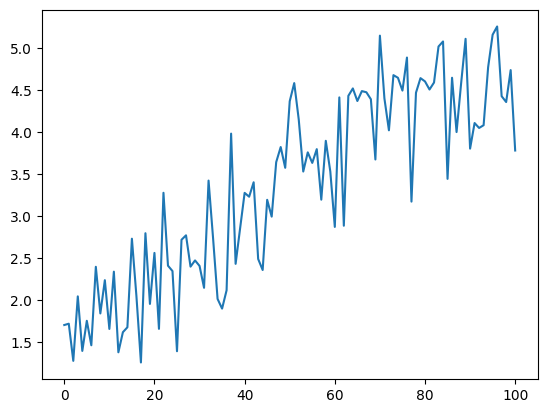

In [28]:
import matplotlib.pyplot as plt
import numpy as np

reward_means = [stat['env/reward_mean'] for stat in all_stats]
plt.plot(reward_means)
plt.show()

## Model inspection
Let's inspect some examples from the IMDB dataset. We can use `ref_model` to compare the tuned model `model` against the model before optimisation.

In [29]:
import pandas as pd

#### get a batch from the dataset
bs = 16
game_data = dict()
ds.set_format("pandas")
df_batch = ds[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "temperature" : 0.8,
    "pad_token_id": tokenizer.eos_token_id,
}

def reward_function(rm_model_output):
    if rm_model_output[0]['score'] > rm_model_output[1]['score']:
        if rm_model_output[0]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[0]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

    elif rm_model_output[1]['score'] > rm_model_output[0]['score']:
        if rm_model_output[1]['label'] == 'POSITIVE':
            return torch.tensor(2*rm_model_output[1]['score'])
        else:
            return torch.tensor(0.5*rm_model_output[0]['score'])

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to('cuda'),
        max_new_tokens=gen_len, **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    
    output = sft_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to('cuda'),
        max_new_tokens=gen_len, **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i])
                                      for i in range(bs)]
game_data["response (after)"] = [tokenizer.decode(response_tensors[i])
                                     for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"],
                               game_data["response (before)"])]
rm_outputs_before = reward_model(texts,
                          **rm_kwargs)
rewards_before = [reward_function(output).numpy().item()
                    for output in rm_outputs_before]
game_data["rewards (before)"] = rewards_before

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
rm_outputs_after = reward_model(texts,
                          **rm_kwargs)
rewards_after = [reward_function(output).numpy().item()
                    for output in rm_outputs_after]
game_data["rewards (after)"] = rewards_after

# store results in a dataframe
pd.set_option('display.max_colwidth', None)
df_results = pd.DataFrame(game_data)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,I thought I was,"going to die,"" she added.\n\n""I thought I was going","very good at making my cool. I haven't regretted it at all,",0.088236,3.131122
1,the cover of the box makes,"you think that the maker's hand is off, and I think that's a good thing. Plus, you get an easy way to recognize the actual","the most wonderful. It is dominated by a beautiful, beautiful, beautiful, beautiful. It is very very beautiful. It is very beautiful. The one",2.682843,5.728671
2,The silent one-panel cartoon,"strip, which was published in 1985, satirized the writer","has a good chance of becoming a great thing, and that",0.116433,3.440557
3,A series of v,"ignettes, dedicated to discussing these events, will be released for the first time during the presentation. A number of information on",-sync on the new serial. All the episodes are great. It's the best and most perfect episode of the season and,3.713008,5.819011
4,I saw this,"coming.""\n\n""Hmm,"" Ginny said, ""I can't believe I just called somebody",. It was a great story. And it was great at its times. It was one of,0.027079,5.740538
5,"When I first saw this movie,","I didn't know what to like. It was so scary, but my family, in my own way, just came in at the end","I was super excited about it. It was a very good story, and it really is one of the most spectacular and wonderful and the most",2.046186,5.729328
6,This Raggedy,"Eyes Ayn Rand, Ayn Rand, Controlled by the Devil, 6",makes an interesting and there are several generations of the importance of reinforcing the piece,0.438122,3.022317
7,Eric Valette,", an independent second-year law student from Kenosha, said, ""I","'s father and grandfather, Valette their time with the it's a great book.",0.016593,4.873795
8,The scenes,"are a little out of date, but I'm curious. All I know is that Amanda and John have become inseparable, and they are both",were memorable for it's now quite good. There is so much now. It's still great. And I enjoy it. It's just just,1.734745,5.741549
9,Welcome to Collinwood,"'s new home, and one of the new neighbourhoods we're looking forward to building in Collinwood. Just 24 minutes drive from the Coll","Center, a great and proud hometown of my immensely special and beautiful and brilliantly beautiful and spectacular and in its kind of the world and I love",3.451687,5.715994


Looking at the reward mean/median of the generated sequences we observe a significant difference.

In [30]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)    2.099912
rewards (after)     4.828698
dtype: float64


median:


rewards (before)    1.975237
rewards (after)     5.448638
dtype: float64

## Save model
Finally, we save the model and push it to the Hugging Face for later usage.

In [31]:
# from huggingface_hub import notebook_login

# notebook_login()

In [32]:
ALIGNED_MODEL_NAME = 'aligned-gpt2-rlhf'

sft_model.save_pretrained(ALIGNED_MODEL_NAME)
tokenizer.save_pretrained(ALIGNED_MODEL_NAME)

('aligned-gpt2-rlhf/tokenizer_config.json',
 'aligned-gpt2-rlhf/special_tokens_map.json',
 'aligned-gpt2-rlhf/vocab.json',
 'aligned-gpt2-rlhf/merges.txt',
 'aligned-gpt2-rlhf/added_tokens.json',
 'aligned-gpt2-rlhf/tokenizer.json')

In [33]:
# sft_model.push_to_hub('dipanjanS/'+ALIGNED_MODEL_NAME)
# tokenizer.push_to_hub('dipanjanS/'+ALIGNED_MODEL_NAME)

In [34]:
reviews = [
    "If I have to review this movie, I would",
    "How could anyone",
    "The makers of this movie don't care",
    "I did not expect this",
    "The thing about this movie which",
    "Here are my 2 cents on the movie",
    "This movie is not a",
    "This is not the",
    "Did not expect this movie"
]

In [35]:
rlhf_model = AutoModelForCausalLMWithValueHead.from_pretrained(ALIGNED_MODEL_NAME,
                                                               device_map='cuda')
aligned_tokenizer = AutoTokenizer.from_pretrained(ALIGNED_MODEL_NAME)


vanilla_model = AutoModelForCausalLMWithValueHead.from_pretrained('openai-community/gpt2',
                                                                  cache_dir='./vanilla',
                                                                  device_map='cuda')
vanilla_tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')

Some weights of the model checkpoint at aligned-gpt2-rlhf were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [36]:
from IPython.display import display, Markdown

In [37]:
for review in reviews:
    inputs = aligned_tokenizer(review, return_tensors="pt",
                               return_token_type_ids=False).to('cuda')
    print("----ALIGNED-MODEL ----")
    outputs = rlhf_model.generate(**inputs,
                                  eos_token_id=aligned_tokenizer.eos_token_id,
                                  pad_token_id=aligned_tokenizer.eos_token_id,
                                  max_new_tokens=32,
                                  temperature=0.8,
                                  do_sample=True)
    display(Markdown((aligned_tokenizer.decode(outputs[0],
                                               skip_special_tokens=True))))
    print("---- NON-ALIGNED-MODEL ----")
    inputs = vanilla_tokenizer(review, return_tensors="pt",
                               return_token_type_ids=False).to('cuda')
    outputs = vanilla_model.generate(**inputs,
                                     eos_token_id=vanilla_tokenizer.eos_token_id,
                                     pad_token_id=vanilla_tokenizer.eos_token_id,
                                     max_new_tokens=32,
                                     temperature=0.8,
                                     do_sample=True)
    display(Markdown((vanilla_tokenizer.decode(outputs[0],
                                               skip_special_tokens=True))))
    print("---- END ----")
    print()

----ALIGNED-MODEL ----


If I have to review this movie, I would recommend it for everyone. It's a wonderful story. It's beautiful, and it's very enjoyable. It's terrific. It's beautiful, and it's

---- NON-ALIGNED-MODEL ----


If I have to review this movie, I would strongly suggest it because the screenplay contains a lot of twists and turns. It's very dark but very gripping. And I'm glad that the story focuses on two

---- END ----

----ALIGNED-MODEL ----


How could anyone have seen this? It's really stunning. It's wonderful. We've got this thing, it's beautiful. It's beautiful. It's beautiful. It

---- NON-ALIGNED-MODEL ----


How could anyone want to know what this means for my career?

As someone who has not spent any time on the internet, I can tell you that I'm very

---- END ----

----ALIGNED-MODEL ----


The makers of this movie don't care about any of you except the fact that it's gorgeous. It's a wonderful little film. It's very, very, absolutely beautiful. It's beautiful.

---- NON-ALIGNED-MODEL ----


The makers of this movie don't care. They are so focused on making an amazing film that they do not care about getting the money they want from people to make it.

It's a

---- END ----

----ALIGNED-MODEL ----


I did not expect this to have a good quality quality. It was pretty good overall. The book was good and the world that it was and the world it was is absolutely right.

---- NON-ALIGNED-MODEL ----


I did not expect this. There is something wrong here. I am a student at the University and I have to be taught."

The man was taken from the scene and booked

---- END ----

----ALIGNED-MODEL ----


The thing about this movie which I like is it's very simple. It is, very simple and very happy to be in it. I think it's a very well made, very well

---- NON-ALIGNED-MODEL ----


The thing about this movie which is more about the people, of the people, you know, is it's based on a movie, it's based on a story, it's based on

---- END ----

----ALIGNED-MODEL ----


Here are my 2 cents on the movie. It was great. It's just wonderful. A lot of things are still very alive. It's my favorite movie. I absolutely love it, and I

---- NON-ALIGNED-MODEL ----


Here are my 2 cents on the movie:

1. The movie is a little bit of a hit. It doesn't look like it was meant to be. I'll admit, as you

---- END ----

----ALIGNED-MODEL ----


This movie is not a great movie, but it's pretty good and I think it's absolutely wonderful. Just a lot of great stuff, it's a great thing, it's brilliant

---- NON-ALIGNED-MODEL ----


This movie is not a sequel. It's not a sequel to The Hobbit. It's not a sequel to Lord of the Rings. It's not a sequel to The Lord of the

---- END ----

----ALIGNED-MODEL ----


This is not the best looking, most beautiful, most beautiful. It's truly stunning. It's very beautiful. It's definitely not the best. It's definitely the most beautiful

---- NON-ALIGNED-MODEL ----


This is not the only time Apple has done that."

According to a report from Reuters, Apple CEO Tim Cook had recently described the "crisis" over the recent decision

---- END ----

----ALIGNED-MODEL ----


Did not expect this movie. It is great and exciting. It's absolutely perfect. I'm very proud of what I found. I think it's just one of those great movies,

---- NON-ALIGNED-MODEL ----


Did not expect this movie to be well received. But I just love it!

---- END ----



Thus we can see the tuned GPT-2 model has been aligned more to generate positive content overall

In [38]:
# cleanup
!rm -rf aligned-gpt2-rlhf
!rm -rf ref
!rm -rf sft
!rm -rf vanilla